## Setup Environment

In [ ]:
# Install specific libraries
! pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 136.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for splitting data and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch and Transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# Set the device to GPU (cuda) if available, otherwise CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using CPU instead.')

Using GPU: Tesla T4


In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [ ]:
# Load Dataset
news = pd.read_csv('/content/drive/My Drive/Capstone_Project_Three/Data/news_classification_Feb29_24.csv')
test = pd.read_csv('/content/drive/My Drive/Capstone_Project_Three/Data/test_set_Feb29_2024.csv')

In [ ]:
news.label = news.label.map({'fake_news':0, 'real_news':1})
test.label = test.label.map({'fake_news':0, 'real_news':1})

## Train-val-test-split

In [ ]:
X = news.title
y = news.label

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_test = test.title
y_test = test.label

## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

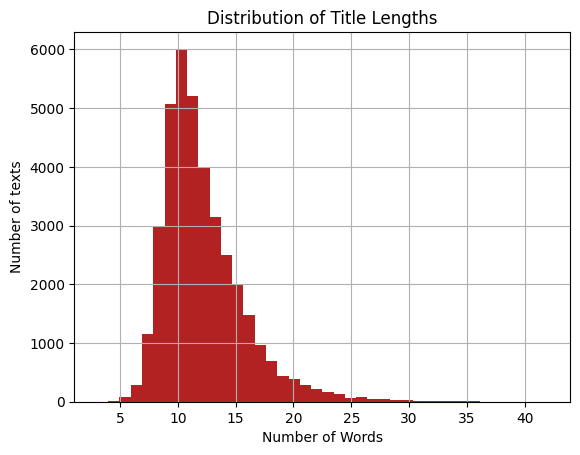

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in news.title]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')
plt.title('Distribution of Title Lengths')
plt.show()

In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGTH = 35
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True)

In [ ]:
len(tokens_train['input_ids']),len(tokens_train['attention_mask']), len(y_train)

(33791, 33791, 33791)

In [ ]:
len(tokens_val['input_ids']),len(tokens_val['attention_mask']), len(y_val)

(3755, 3755, 3755)

In [ ]:
len(tokens_test['input_ids']),len(tokens_test['attention_mask']), len(y_test)

(25, 25, 25)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [ ]:
train_seq.shape, train_mask.shape, train_y.shape

(torch.Size([33791, 35]), torch.Size([33791, 35]), torch.Size([33791]))

In [ ]:
val_seq.shape, val_mask.shape, val_y.shape

(torch.Size([3755, 35]), torch.Size([3755, 35]), torch.Size([3755]))

In [ ]:
test_seq.shape, test_mask.shape, test_y.shape

(torch.Size([25, 35]), torch.Size([25, 35]), torch.Size([25]))

In [ ]:
# Define batch size
batch_size = 32                                              #define a batch size
# Wrap tensors into a TensorDataset and create a DataLoader for the training set
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create a DataLoader for the validation set                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure (Optional but Recommended for Initial Fine-tuning)**
# We freeze the weights of the pre-trained BERT layers. This means we will only train the new classifier layers we add on top.
# This is faster and prevents the powerful pre-trained weights from being distorted by early, random gradients.
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert

      # --- CLASSIFIER HEAD ---
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)

    def forward(self, sent_id, mask):           # define the forward pass
      # Pass input through BERT
      # We take the `last_hidden_state`
      outputs = self.bert(sent_id, attention_mask=mask)
      # Use the hidden state of the [CLS] token (the first token) for classification
      cls_hidden_state = outputs.last_hidden_state[:, 0, :]
      # Pass the [CLS] token's state through our classifier head
      x = self.fc1(cls_hidden_state)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      return x

# Instantiate the model and move it to the configured device (GPU or CPU)
model = BERT_Arch(bert)
model.to(device)

# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer

optimizer = AdamW(model.parameters(), lr = 1e-3)          # learning rate

# Define the loss function
cross_entropy  = nn.CrossEntropyLoss()
# Number of training epochs
epochs = 5

### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    # Progress update
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]                                 # push the batch to gpu
    sent_id, mask, labels = batch

    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU
    labels = labels.cpu().numpy()
    total_accuracy += np.sum(np.argmax(preds, axis=1) == labels)

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  avg_accuracy = total_accuracy / len(train_data)
  return avg_loss, avg_accuracy                               # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t.to(device) for t in batch]                   # Push the batch to GPU
    sent_id, mask, labels = batch

    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()
      total_accuracy += np.sum(np.argmax(preds, axis=1) == labels)

  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  avg_accuracy = total_accuracy / len(val_data)
  return avg_loss, avg_accuracy

### Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, train_acc = train()                       # train model
    valid_loss, valid_acc = evaluate()                    # evaluate model

    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert_fakenews_model.pt')

    # Store metrics for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f} | Training Accuracy: {train_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f} | Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
  Batch    50  of  1,056.
  Batch   100  of  1,056.
  Batch   150  of  1,056.
  Batch   200  of  1,056.
  Batch   250  of  1,056.
  Batch   300  of  1,056.
  Batch   350  of  1,056.
  Batch   400  of  1,056.
  Batch   450  of  1,056.
  Batch   500  of  1,056.
  Batch   550  of  1,056.
  Batch   600  of  1,056.
  Batch   650  of  1,056.
  Batch   700  of  1,056.
  Batch   750  of  1,056.
  Batch   800  of  1,056.
  Batch   850  of  1,056.
  Batch   900  of  1,056.
  Batch   950  of  1,056.
  Batch 1,000  of  1,056.
  Batch 1,050  of  1,056.

Evaluating...
  Batch    50  of    118.
  Batch   100  of    118.

Training Loss: 0.193 | Training Accuracy: 0.922
Validation Loss: 0.126 | Validation Accuracy: 0.951

 Epoch 2 / 5
  Batch    50  of  1,056.
  Batch   100  of  1,056.
  Batch   150  of  1,056.
  Batch   200  of  1,056.
  Batch   250  of  1,056.
  Batch   300  of  1,056.
  Batch   350  of  1,056.
  Batch   400  of  1,056.
  Batch   450  of  1,056.
  Batch   500  of  1,056

### Model performance

In [ ]:
# load weights of best model
model.load_state_dict(torch.load('bert_fakenews_model.pt'))

<All keys matched successfully>

In [ ]:
# Move test tensors to the device
test_seq_gpu = test_seq.to(device)
test_mask_gpu = test_mask.to(device)

In [ ]:
with torch.no_grad():
  preds = model(test_seq_gpu, test_mask_gpu)
  preds = preds.detach().cpu().numpy()

# Get the predicted labels by taking the argmax
predicted_labels = np.argmax(preds, axis=1)

In [ ]:
# Generate the classification report
print("------ Classification Report ------")
print(classification_report(y_test, predicted_labels, target_names=['Fake News', 'Real News']))

------ Classification Report ------
              precision    recall  f1-score   support

   Fake News       0.92      1.00      0.96        12
   Real News       1.00      0.92      0.96        13

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

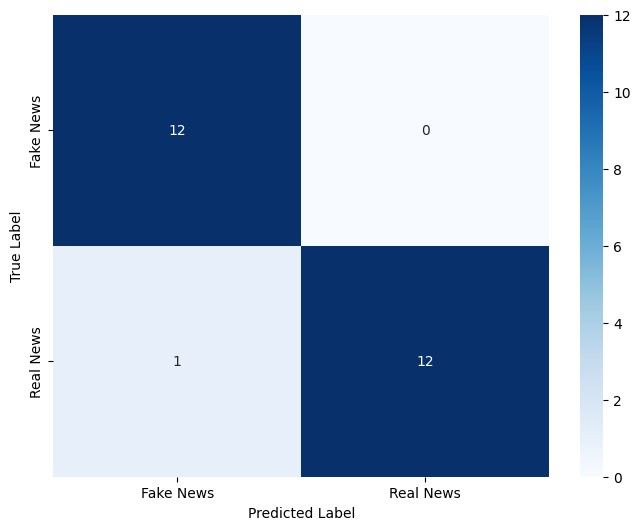

In [ ]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt